In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import nanotube
from ase.neighborlist import NeighborList
from qtpyt.base.leads import LeadSelfEnergy


In [2]:
def create_nanotube(n=6, m=0, length=2, bond=1.42, pbc=True, direction="x"):
    """Create a carbon nanotube (CNT) using ASE.

    Args:
        n (int): Chiral index n.
        m (int): Chiral index m.
        length (int): Number of unit cells.
        bond (float): Carbon-carbon bond length.
        pbc (bool): Whether to apply periodic boundary conditions.
        direction (str): Direction of periodicity ('x', 'y', or 'z').

    Returns:
        ase.Atoms: ASE Atoms object representing the CNT.
    """
    atoms = nanotube(n=n, m=m, length=length, bond=bond, verbose=False)
    atoms.rotate("z", "x", rotate_cell=True, center="COP")
    if pbc:
        if direction == "x":
            atoms.set_pbc((1, 0, 0))
        elif direction == "y":
            atoms.set_pbc((0, 1, 0))
        elif direction == "z":
            atoms.set_pbc((0, 0, 1))
        else:
            raise ValueError("Invalid direction. Use 'x', 'y', or 'z'.")
    return atoms

def build_real_space_CNT_hamiltonian(
    atoms, bond=1.42, beta=0.0, t0=-2.7, neighbor_cutoff=1.43, atol=0.1
):
    """Build the intra-cell (H0) and inter-cell (T) Hamiltonians for a CNT lead.

    Args:
        atoms (ase.Atoms): CNT structure with two unit cells.
        bond (float): Ideal bond length (in angstrom).
        beta (float): Exponential decay parameter for hopping.
        t0 (float): Nearest-neighbor hopping at ideal bond length (in eV).
        neighbor_cutoff (float): Distance threshold to consider neighbors.
        atol (float): Absolute tolerance in bond length matching.

    Returns:
        Tuple[np.ndarray, np.ndarray]: H0 and T matrices (both shape (N, N)).
    """
    N_total = len(atoms)
    N_unit = N_total // 2  # atoms in one unit cell

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    # Neighbor list
    cutoffs = [neighbor_cutoff] * N_total
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    # Initialize Hamiltonians
    H0 = np.zeros((N_unit, N_unit), dtype=float)
    T = np.zeros((N_unit, N_unit), dtype=float)

    for i in range(N_total):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j <= i:
                continue
            ri = positions[i]
            rj = positions[j] + np.dot(offset, cell)
            dist = np.linalg.norm(ri - rj)
            if np.abs(dist - bond) > atol:
                continue  # skip non-neighbors
            hopping = t0 * np.exp(-beta * (dist / bond - 1))

            # Intra-cell bond
            if i < N_unit and j < N_unit:
                H0[i, j] = hopping
                H0[j, i] = hopping

            # Inter-cell bond
            elif i < N_unit and j >= N_unit:
                T[i, j - N_unit] = hopping

    return H0, T

def add_broadening(CNT_self_energy, eta_pt, interface_indices=None):
    """
    Add phenomenological broadening to CNT self-energy to simulate Pt hybridization.

    Parameters
    ----------
    CNT_self_energy : ndarray
        Original CNT self-energy (shape (N, N)).
    eta_pt : float
        Imaginary broadening value (in eV).
    interface_indices : list of int or None
        If given, applies -i*eta_pt only to these orbital indices.
        If None, applies uniform broadening to all orbitals.

    Returns
    -------
    effective_self_energy : ndarray
        Modified self-energy with -i η I or localized broadening.
    """
    effective_self_energy = CNT_self_energy.copy()
    N = CNT_self_energy.shape[0]

    if interface_indices is None:
        # Uniform broadening
        effective_self_energy -= 1j * eta_pt * np.eye(N)
    else:
        # Localized broadening
        for i in interface_indices:
            effective_self_energy[i, i] -= 1j * eta_pt

    return effective_self_energy


In [3]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
first_neighbor_hopping = -2.7  # eV
beta = 0  # 3.37
neighbor_cutoff = 1.43  # Å for nearest neighbors
eta = 1e-8  # eV

leads = create_nanotube(n=n, m=m, length=ncells, bond=bond, pbc=True, direction="x")
H0_leads, V_leads = build_real_space_CNT_hamiltonian(
    leads,
    beta=beta,
    t0=first_neighbor_hopping,
    neighbor_cutoff=neighbor_cutoff,
    atol=0.1,
)
S0_leads = np.eye(H0_leads.shape[0])  # Overlap within unit cell
S1_leads = np.zeros_like(H0_leads)  # Overlap between cells

# Initialize self-energy list for left and right leads
self_energy = [None, None]

# Create LeadSelfEnergy objects for left and right leads
# Uses Sancho Rubio method to compute the surface Green's function
self_energy[0] = LeadSelfEnergy(
    (H0_leads, S0_leads),
    (V_leads, S1_leads),
    eta=eta,
)
self_energy[1] = LeadSelfEnergy(
    (H0_leads, S0_leads),
    (V_leads, S1_leads),
    id="right",
    eta=eta,
)


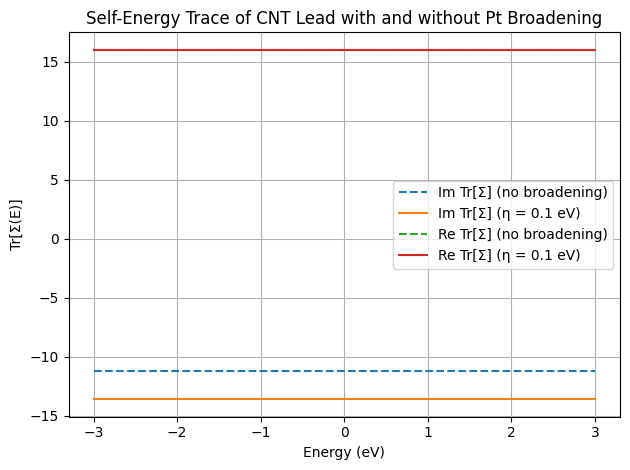

In [4]:
energies = np.linspace(-3, 3, 100)
eta_pt = 0.1  # eV, broadening due to Pt

# Compute unbroadened self-energy
selfenergy_clean = np.array([
    self_energy[0].retarded(E) for E in energies
])
trace_clean = np.trace(selfenergy_clean, axis1=1, axis2=2)

# Compute broadened self-energy
selfenergy_broadened = np.array([
    add_broadening(se, eta_pt=eta_pt) for se in selfenergy_clean
])
trace_broadened = np.trace(selfenergy_broadened, axis1=1, axis2=2)

# Plot imaginary parts
plt.plot(energies, trace_clean.imag, label='Im Tr[Σ] (no broadening)', linestyle='--')
plt.plot(energies, trace_broadened.imag, label=f'Im Tr[Σ] (η = {eta_pt} eV)', linestyle='-')

# Plot real parts
plt.plot(energies, trace_clean.real, label='Re Tr[Σ] (no broadening)', linestyle='--')
plt.plot(energies, trace_broadened.real, label=f'Re Tr[Σ] (η = {eta_pt} eV)', linestyle='-')

plt.xlabel('Energy (eV)')
plt.ylabel('Tr[Σ(E)]')
plt.title('Self-Energy Trace of CNT Lead with and without Pt Broadening')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
